### 載入套件

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 讀檔

In [2]:
df = pd.read_csv('place_info_final_3.csv', index_col=0)
df = df.drop(columns='file_name_2')

### 查看原始資料欄位及空缺值

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25145 entries, 0 to 25144
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   google_url              25145 non-null  object 
 1   place_name              25145 non-null  object 
 2   total_rating            25145 non-null  float64
 3   place_category          25145 non-null  object 
 4   total_reviews           25145 non-null  float64
 5   cost                    12146 non-null  object 
 6   address                 25145 non-null  object 
 7   district                25145 non-null  object 
 8   eat_in                  25145 non-null  int64  
 9   to_go_1                 25145 non-null  int64  
 10  to_go_2                 25145 non-null  int64  
 11  delivery                25145 non-null  int64  
 12  opening_hours           23888 non-null  object 
 13  website                 16167 non-null  object 
 14  phone                   23362 non-null

### 檢查資料是否重複

In [4]:
print('google_url是否重複: ',df['google_url'].duplicated().any())
print('店名+地址是否重複: ',df[['address', 'place_name']].duplicated().any())
print('file_name_1是否重複: ',df['file_name_1'].duplicated().any())

google_url是否重複:  False
店名+地址是否重複:  True
file_name_1是否重複:  False


### 刪除(店名+地址)重複

In [5]:
df2 = df.drop_duplicates(subset=['address', 'place_name'])
print('刪除(店名+地址)重複後資料筆數: ', df2.shape[0])

刪除(店名+地址)重複後資料筆數:  25061


### 刪除缺少營業時間row

In [6]:
df2 = df[~df['opening_hours'].isna()]
print('刪除(營業時間)缺失後資料筆數: ', df2.shape[0])

刪除(營業時間)缺失後資料筆數:  23888


### 篩選可內用

In [7]:
df2 = df2[df2['eat_in'] == 1]
print('(可內用)資料筆數: ', df2.shape[0])

(可內用)資料筆數:  20657


### 刪除評論數小於50

In [8]:
df2 = df2[df2['total_reviews'] > 30]
print('刪除(評論數 < 50)後資料筆數: ', df2.shape[0])

刪除(評論數 < 50)後資料筆數:  18345


### 新增Category_new欄位，mapping according to type_all.csv

In [9]:
type_all = pd.read_csv('type_all.csv', index_col=0, squeeze=True).to_dict()
df2['category_new'] = df2['file_name_1'].map(type_all)

C:\Users\student\AppData\Local\Temp\ipykernel_10656\2276532800.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  type_all = pd.read_csv('type_all.csv', index_col=0, squeeze=True).to_dict()


### 刪除篩選類別後需要剔除的項目 category_new = Nan

In [10]:
df2 = df2.dropna(subset='category_new')
print('刪除(需剔除項目)後資料筆數: ', df2.shape[0])

刪除(需剔除項目)後資料筆數:  16521


### 新增 district_new 分類行政區

In [11]:
df2["district_new"] = df2["district"].str.split(" ").str.get(3)
df2 = df2.drop(df2[df2['district_new'] == '汐止區'].index)

### 新增緯經度 location 欄位

In [12]:
df2['location'] = df2['google_url'].str.findall('\d?\d\d\.\d+')
df_expanded_v0 = df2["location"].apply(pd.Series)
df2['latitude'] = df_expanded_v0[0]
df2['longitude'] = df_expanded_v0[1]

### 營業時間欄位新增

In [13]:
def open_time(weekday, str_weekday):
    for i in df2[str_weekday]:
        listt = []
        if len(i) == 0:
            listt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        elif len(i) == 1:
            listt = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

        if len(i) > 1:
            # 晚上營業時間沒有跨日
            if int(i[-1]) - int(i[0]) > 0:
                listt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                if len(i) >= 2:
                    listt[int(i[0]):int(i[1])] = np.ones(abs(int(i[1])-int(i[0])))

                    if len(i) >= 4:
                        listt[int(i[2]):int(i[3])] = np.ones(abs(int(i[3])-int(i[2])))

                        if len(i) >= 6:
                            listt[int(i[4]):int(i[5])] = np.ones(int(i[5])-int(i[4]))

                            if len(i) >= 8:
                                listt[int(i[6]):int(i[7])] = np.ones(int(i[7])-int(i[6]))

            # 晚上營業時間跨日    
            if int(i[-1]) - int(i[0]) < 0:
                listt = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

                if len(i) >= 2:
                    listt[int(i[-1]):int(i[0])] = np.zeros(abs(int(i[-1])-int(i[0])))

                    if len(i) >= 4:
                        listt[int(i[1]):int(i[2])] = np.zeros(abs(int(i[2])-int(i[2])))

                        if len(i) >= 6:
                            listt[int(i[3]):int(i[4])] = np.zeros(abs(int(i[4])-int(i[3])))

                            if len(i) >= 8:
                                listt[int(i[5]):int(i[6])] = np.zeros(abs(int(i[6])-int(i[5])))

        weekday.append(listt)

In [14]:
df2['week_list'] = df2['opening_hours'].str.replace(' ','') #去除空白
df2['week_list'] = df2['week_list'].str.split(';') #以;分隔成list
blank = []

# 排序 一三二五六四日
for i in df2['week_list']:
    blank.append(sorted(i))

df2['week_list'] = blank

df_expanded_v1 = df2["week_list"].apply(pd.Series)

monday = []
tuesday = []
wednesday = []
thursday = []
friday = []
saturday = []
sunday = []
weeklist = [[monday, 'monday'], [tuesday,'tuesday'], [wednesday,'wednesday'], [thursday,'thursday'],
            [friday,'friday'],[saturday, 'saturday'],[sunday,'sunday']]

df2['monday'] = df_expanded_v1[0]
df2['tuesday'] = df_expanded_v1[2]
df2['wednesday'] = df_expanded_v1[1]
df2['thursday'] = df_expanded_v1[5]
df2['friday'] = df_expanded_v1[3]
df2['saturday'] = df_expanded_v1[4]
df2['sunday'] = df_expanded_v1[6]

# 把營業時間轉成[num,num]
for i, j in weeklist:
    df2[j] = df2[j].str.replace(':\d\d','')
    df2[j] = df2[j].str.findall('\d\d')

# 去除掉沒有營業時間
df2 = df2[~df2['thursday'].isna()]

for i, j in weeklist:
    open_time(i, j)
    df2[j] = i

C:\Users\student\AppData\Local\Temp\ipykernel_10656\2294360129.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df2[j] = df2[j].str.replace(':\d\d','')


In [18]:
df2.to_csv('cool.csv')

In [17]:
df_expanded_v2

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25138,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_expanded_v2 = df2["monday"].apply(pd.Series)
df_expanded_v2.iloc[:,0:24]

C:\Users\student\AppData\Local\Temp\ipykernel_10656\4122065772.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_expanded_v2 = df2["monday"].apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
25134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25138,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


# 餐廳類別分布

<AxesSubplot:xlabel='category_new', ylabel='count'>

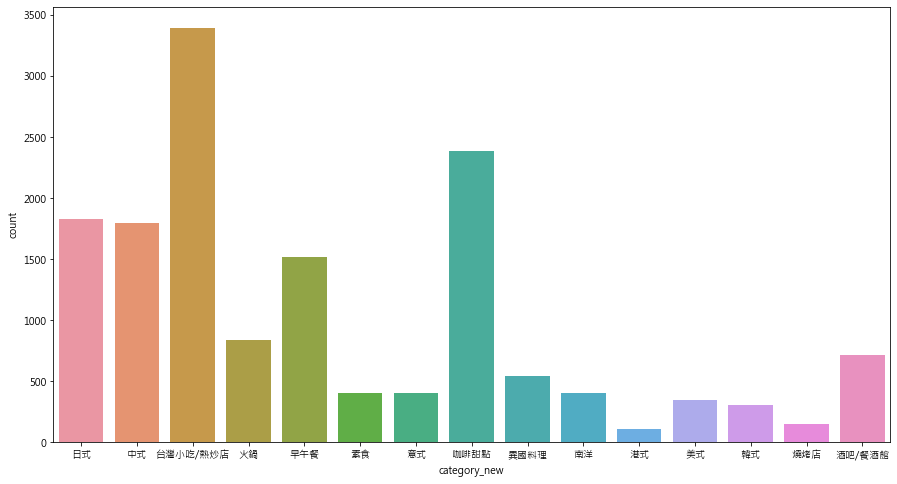

In [19]:
plt.figure(figsize = (15,8))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
sns.countplot(x=df2["category_new"])

# 行政區類別分布

<AxesSubplot:xlabel='district_new', ylabel='count'>

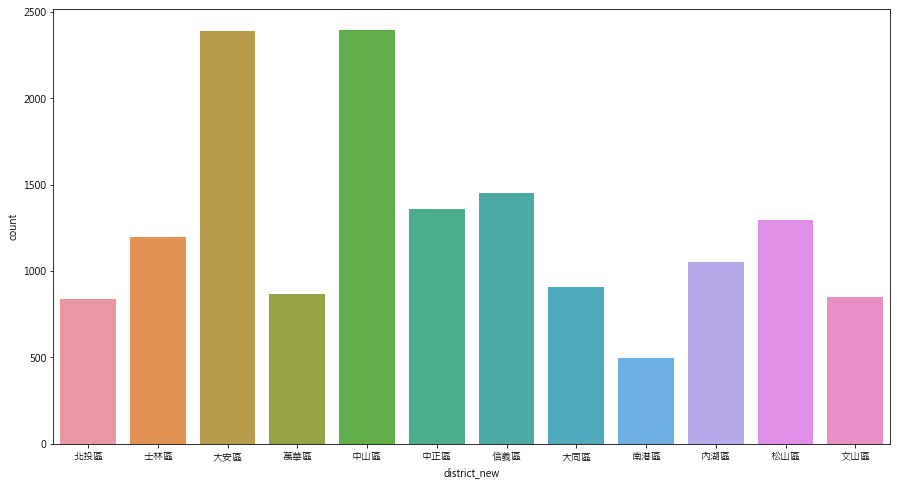

In [20]:
plt.figure(figsize = (15,8))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
sns.countplot(x=df2["district_new"])

# 評論數&星數

<AxesSubplot:xlabel='total_rating', ylabel='total_reviews'>

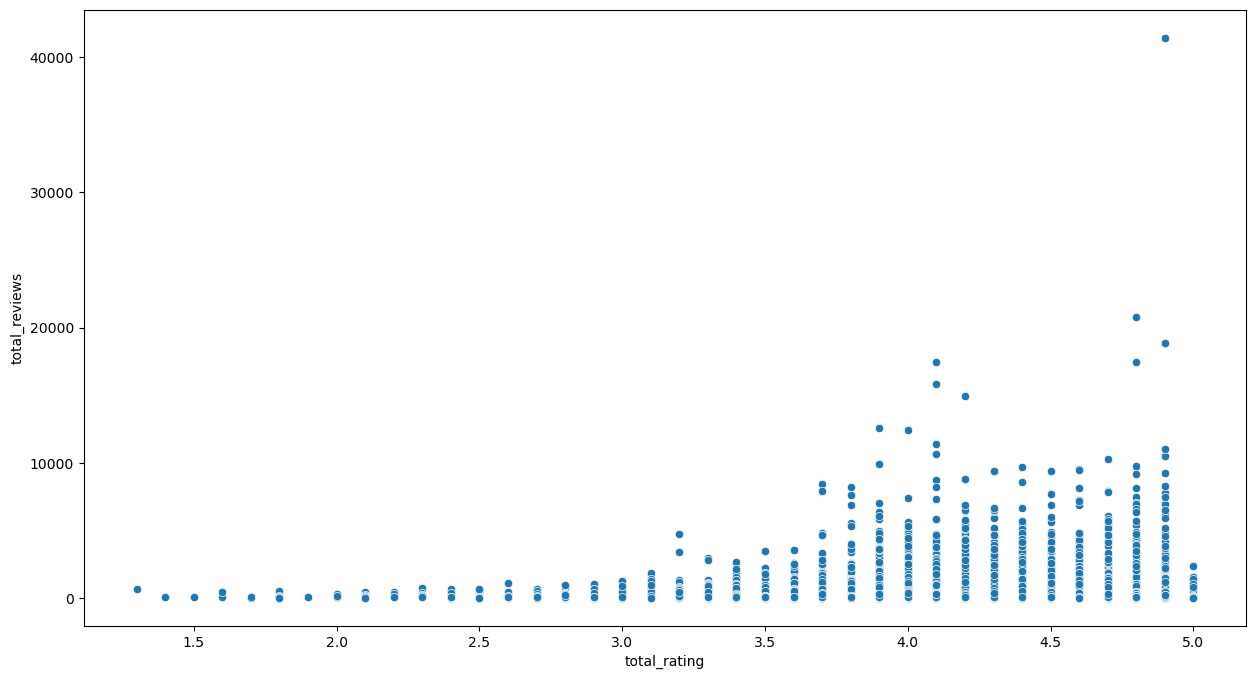

In [44]:
plt.figure(figsize = (15,8))
sns.scatterplot(x = df2['total_rating'], y = df2['total_reviews'])

# 評論數分布

In [39]:
df2.loc[df2['total_reviews'] <= 50, 'new_review'] = '<50'
df2.loc[(df2['total_reviews'] > 50) & (df2['total_reviews'] <= 100), 'new_review'] = '51-100'
df2.loc[(df2['total_reviews'] > 100) & (df2['total_reviews'] <= 200), 'new_review'] = '101-200'
df2.loc[(df2['total_reviews'] > 200) & (df2['total_reviews'] <= 300), 'new_review'] = '201-300'
df2.loc[(df2['total_reviews'] > 300) & (df2['total_reviews'] <= 400), 'new_review'] = '301-400'
df2.loc[(df2['total_reviews'] > 400) & (df2['total_reviews'] <= 500), 'new_review'] = '401-500'
df2.loc[(df2['total_reviews'] > 500) & (df2['total_reviews'] <= 600), 'new_review'] = '501-600'
df2.loc[(df2['total_reviews'] > 600) & (df2['total_reviews'] <= 700), 'new_review'] = '601-700'
df2.loc[(df2['total_reviews'] > 700) & (df2['total_reviews'] <= 800), 'new_review'] = '701-800'
df2.loc[(df2['total_reviews'] > 800) & (df2['total_reviews'] <= 900), 'new_review'] = '801-900'
df2.loc[(df2['total_reviews'] > 900) & (df2['total_reviews'] <= 1000), 'new_review'] = '901-1000'
df2.loc[(df2['total_reviews'] > 1000) & (df2['total_reviews'] <= 2000), 'new_review'] = '1001-2000'
df2.loc[(df2['total_reviews'] > 2000) & (df2['total_reviews'] <= 3000), 'new_review'] = '2001-3000'
df2.loc[(df2['total_reviews'] > 3000) & (df2['total_reviews'] <= 4000), 'new_review'] = '3001-4000'
df2.loc[(df2['total_reviews'] > 4000) & (df2['total_reviews'] <= 5000), 'new_review'] = '4001-5000'
df2.loc[(df2['total_reviews'] > 5000), 'new_review'] = '>5000'

<AxesSubplot:xlabel='new_review', ylabel='count'>

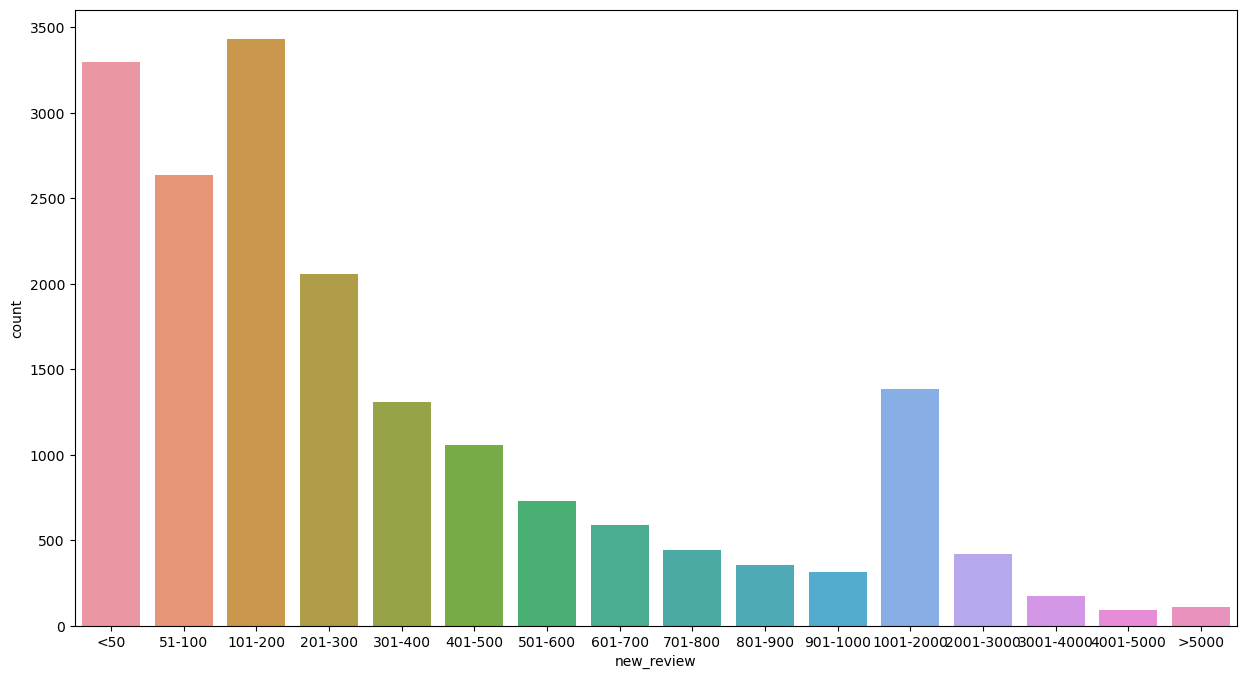

In [73]:
plt.figure(figsize = (15,8))
sns.countplot(x = df2['new_review'], order=['<50', '51-100','101-200','201-300','301-400','401-500','501-600','601-700','701-800','801-900','901-1000','1001-2000','2001-3000','3001-4000','4001-5000','>5000'])

# 評論星數分布

<AxesSubplot:xlabel='total_rating', ylabel='count'>

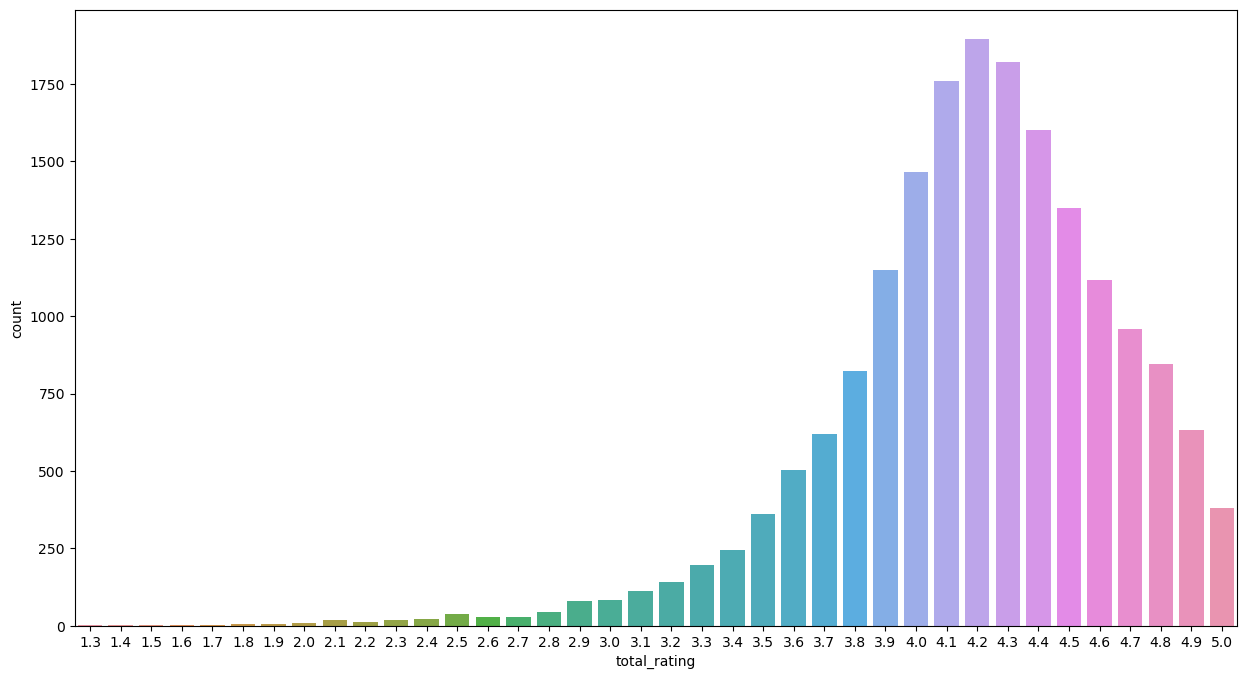

In [21]:
plt.figure(figsize = (15,8))
sns.countplot(x = df2['total_rating'])

偏度(Skewness): -1.21, 峰度(Kurtosis): 3.77


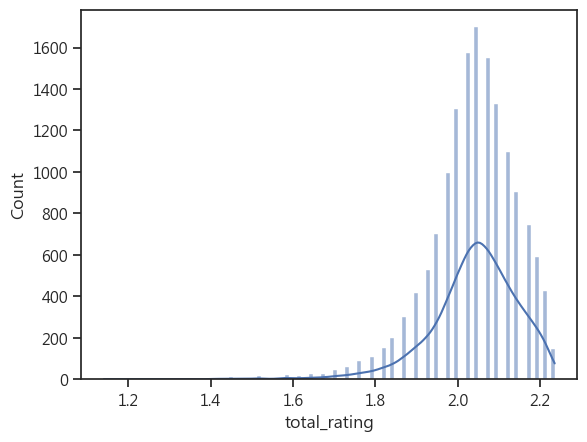

In [443]:
transform_data = df2['total_rating']**(1/2)
# skewness 與 kurtosis
skewness = round(transform_data.skew(), 2)
kurtosis = round(transform_data.kurt(), 2)
print(f"偏度(Skewness): {skewness}, 峰度(Kurtosis): {kurtosis}")

# 繪製分布圖
sns.histplot(transform_data, kde=True)
plt.show()

偏度(Skewness): -1.64, 峰度(Kurtosis): 6.75


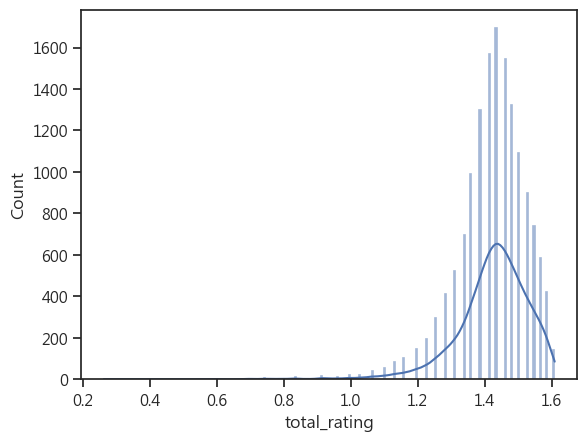

In [442]:
transform_data = np.log(df2['total_rating'])
# skewness 與 kurtosis
skewness = round(transform_data.skew(), 2)
kurtosis = round(transform_data.kurt(), 2)
print(f"偏度(Skewness): {skewness}, 峰度(Kurtosis): {kurtosis}")

# 繪製分布圖
sns.histplot(transform_data, kde=True)
plt.show()

In [434]:
df2.describe()

,total_rating,total_reviews,eat_in,to_go_1,to_go_2,delivery,close,file_name_1
count,15084.000000,15084.000000,15084.0,15084.000000,15084.000000,15084.000000,0.0,15084.000000
mean,4.178215,570.553302,1.0,0.843477,0.106006,0.484288,NaN,11004.883121
std,0.426257,993.532935,0.0,0.363363,0.307856,0.499770,NaN,7031.869812
min,1.300000,51.000000,1.0,0.000000,0.000000,0.000000,NaN,0.000000
25%,4.000000,127.000000,1.0,1.000000,0.000000,0.000000,NaN,4978.750000
50%,4.200000,268.000000,1.0,1.000000,0.000000,0.000000,NaN,10219.000000
75%,4.500000,616.000000,1.0,1.000000,0.000000,1.000000,NaN,16463.750000
max,5.000000,41467.000000,1.0,1.000000,1.000000,1.000000,NaN,25141.000000


<AxesSubplot:xlabel='total_rating'>

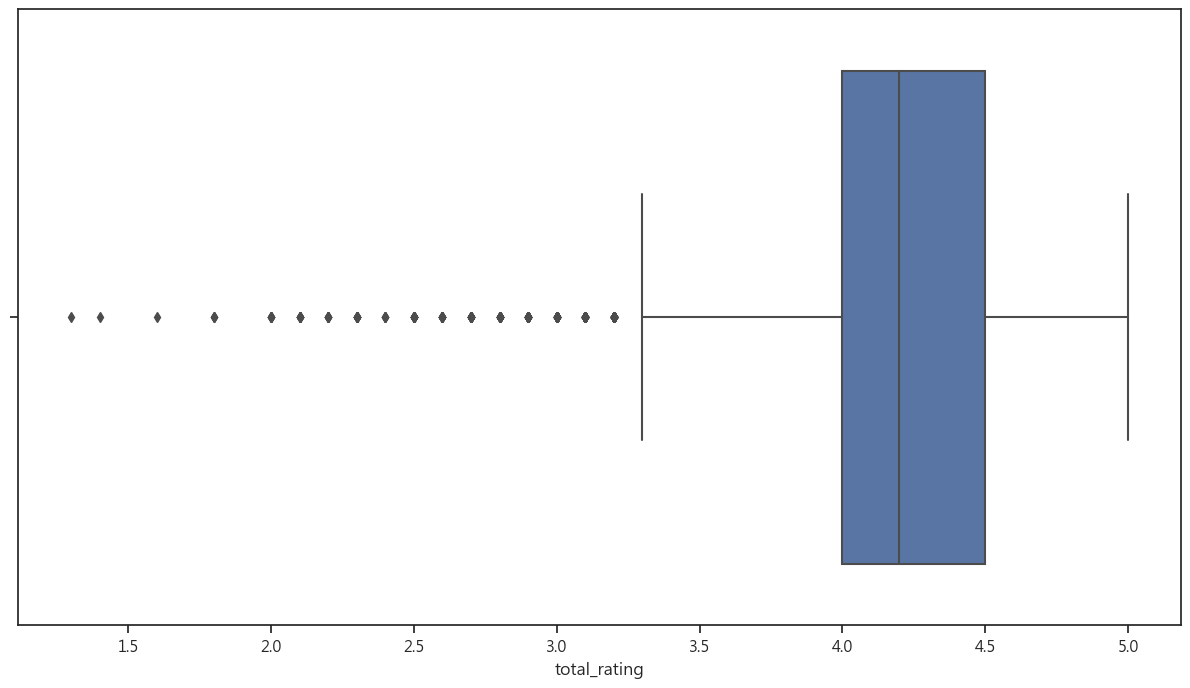

In [433]:
plt.figure(figsize = (15,8))
sns.boxplot(x = df2['total_rating'])